In [3]:
import pandas as pd
import matplotlib.pyplot as plt

Configuração

In [4]:
FILENAME = 'indice-de-evolução-fluxo-vs-média-global.csv'
# Mínimo de fluxos para considerar o dado "confiável"
MIN_SAMPLES = 5
# Zoom no eixo Y para ver os detalhes
Y_LIMITS = (-0.15, 0.15)

Carregamento dos Dados e Limpeza

In [6]:
df = pd.read_csv(FILENAME)
df['time'] = pd.to_datetime(df['time'])
df = df.dropna(subset=['value'])
df['flow_id'] = df['group'].apply(lambda x: x.split(':')[-1])

Normalização Temporal

In [7]:
start_times = df.groupby('flow_id')['time'].min().reset_index()
start_times.rename(columns={'time': 'start_time'}, inplace=True)

df_merged = pd.merge(df, start_times, on='flow_id')
df_merged['elapsed_hours'] = (df_merged['time'] - df_merged['start_time']).dt.total_seconds() / 3600
df_merged['hour_bin'] = df_merged['elapsed_hours'].round().astype(int)

Agregação Estatística

In [8]:
agg_data = df_merged.groupby('hour_bin')['value'].agg(['mean', 'std', 'count']).reset_index()

Identificar Ponto de Corte (Confiabilidade)

In [9]:
low_reliability = agg_data[agg_data['count'] < MIN_SAMPLES]
if not low_reliability.empty:
    cutoff_hour = low_reliability['hour_bin'].min()
else:
    cutoff_hour = agg_data['hour_bin'].max()

Plotagem

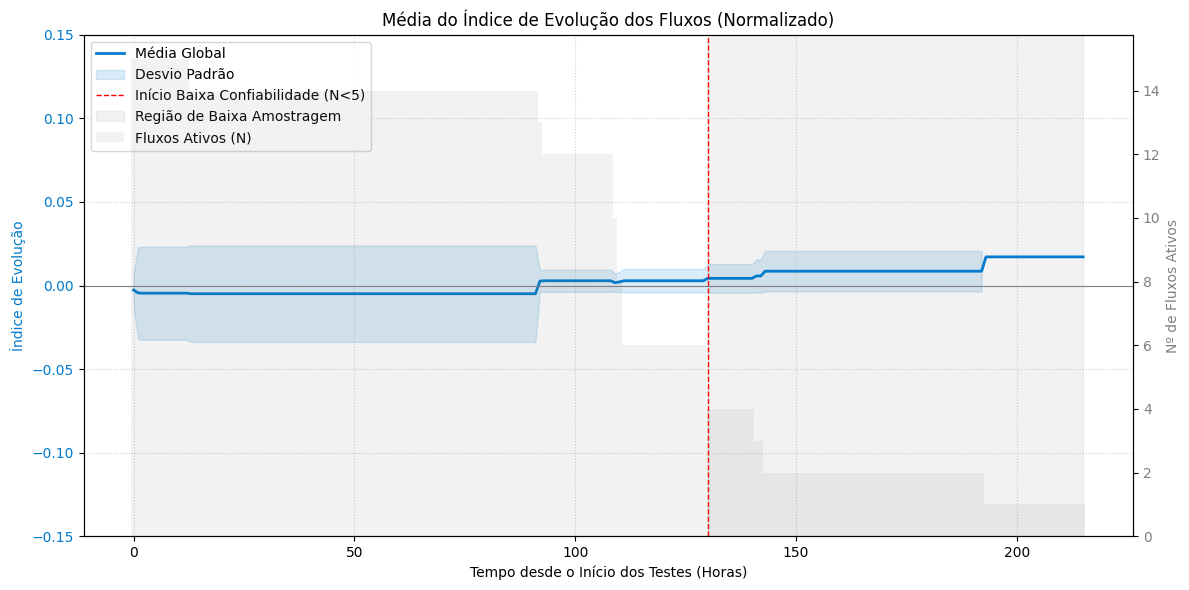

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# -- Eixo Principal (Média e Desvio) --
# Linha da Média
ax1.plot(agg_data['hour_bin'], agg_data['mean'], label='Média Global', color='#007acc', linewidth=2)
# Sombra do Desvio Padrão
ax1.fill_between(agg_data['hour_bin'],
                 agg_data['mean'] - agg_data['std'],
                 agg_data['mean'] + agg_data['std'],
                 color='#007acc', alpha=0.15, label='Desvio Padrão')

# -- Indicadores de Confiabilidade --
plt.axvline(cutoff_hour, color='red', linestyle='--', linewidth=1, label=f'Início Baixa Confiabilidade (N<{MIN_SAMPLES})')
# Pinta a área não confiável de cinza
plt.axvspan(cutoff_hour, agg_data['hour_bin'].max(), color='gray', alpha=0.1, label='Região de Baixa Amostragem')

# -- Eixo Secundário (Volume de Dados) --
ax2 = ax1.twinx()
ax2.bar(agg_data['hour_bin'], agg_data['count'], color='gray', alpha=0.1, width=1, label='Fluxos Ativos (N)')
ax2.set_ylabel('Nº de Fluxos Ativos', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# -- Formatação Final --
ax1.set_title('Média do Índice de Evolução dos Fluxos (Normalizado)')
ax1.set_xlabel('Tempo desde o Início dos Testes (Horas)')
ax1.set_ylabel('Índice de Evolução', color='#007acc')
ax1.tick_params(axis='y', labelcolor='#007acc')
ax1.set_ylim(Y_LIMITS)
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.8)
ax1.grid(True, linestyle=':', alpha=0.6)

# Legenda Unificada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()